# Cat Breed Classification Notebook
This is my notebook for cat breed classification.

<br></br>

## Table of Contents
1. [Dependencies](#dependencies)
2. [Configuration](#configuration)
3. [Functions](#functions)
   - [Helpers](#helpers)
   - [Image Processing](#image-processing)
   - [Data Preparation](#data-preparation)
   - [Model Settings](#model-settings)
   - [Training](#training)
   - [Reporting and Visualization](#reporting-and-visualization)
4. [Execution](#execution)
   - [Prepare Data](#prepare-data)
   - [Create or Load Model](#create-or-load-model)
   - [Train](#train)
   - [Evaluate](#evaluate)
   - [Predict](#predict)
   - [Save](#save)

## Dependencies
Import statements for essential libraries and packages used in the project.

In [1]:
import cv2
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image as PILImage
from tensorflow import keras as ks
from IPython.display import Image, display
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import ConfusionMatrixDisplay

## Configuration
Settings and parameters that helps with the execution and usability of the project.

In [2]:
data_dir = 'data'
predict_dir = 'predict'
log_dir = 'logs'
models_dir = 'models/cat_classifier.keras'
classes_dir = 'models/classes.json'

image_exts = ['jpeg', 'jpg', 'png']
image_size = (224, 224)

debug = True

## Functions
This section includes different reusable functions.

#### Helpers

In [3]:
def extract_class_name(full_class_name):
    """
    Extracts the part of the class name after the '-' character.
    """
    return full_class_name.split('-')[-1]

def save_class_names(classes, classes_path):
    """
    Saves the list of class names to the specified path as a JSON file.

    :classes: List of class names to be saved.
    :classes_path: File path where the class names will be saved.
    """
    try:
        with open(classes_path, 'w') as f:
            json.dump(classes, f)
        print(f"Class names successfully saved to {classes_path}.")
    except Exception as e:
        print(f"Error saving class names: {e}")


def get_true_and_pred_labels(model, dataset):
    """
    Predicts labels based on the provided model and retrieves the corresponding true labels from the dataset.

    :model: Trained Keras model.
    :dataset: Dataset containing images and true labels.

    :returns: Tuple of (images, true_labels, predicted_labels, image_paths)
    """
    images = []
    y_true = []
    y_pred = []

    for images_batch, labels_batch in dataset:
        images.extend(images_batch.numpy())
        y_true.extend(labels_batch.numpy())
        predictions = model.predict(images_batch)
        y_pred.extend(np.argmax(predictions, axis=1))

    return images, np.array(y_true), np.array(y_pred)

#### *Image Processing*

In [4]:
def process_images(dir, exts):
    """
    Processes images in the specified directory based on the provided file extensions.

    :dir: Path to the directory containing subdirectories of images.
    :exts: List of image file extensions.

    :returns: Tuple of (Keras image dataset, image paths)
    """
    valid_image_paths = []

    for ext in exts:
        image_paths = glob.glob(f'{dir}/*/*.{ext}')

        for path in image_paths:
            try:
                PILImage.open(path)
                valid_image_paths.append(path)
            except Exception as e:
                raise ValueError(f'Error processing {path}: {e}') from e

    if not valid_image_paths:
        raise ValueError('No valid images found in the specified directory')

    dataset = ks.utils.image_dataset_from_directory(dir)
    
    return dataset, valid_image_paths

def preprocess_images(dataset):
    """
    Displays random images before and after processing.

    :dataset: Dataset containing images and their corresponding labels.

    :returns: Dataset with normalized images.
    """

    def resize_and_normalize(image, label):
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    processed_dataset = dataset.map(resize_and_normalize)
    return processed_dataset

def get_img_array(img_path, size):
    """
    Loads and preprocesses an image for model input.

    :img_path: Path to the image file.
    :size: Target size as (height, width)
    
    :returns: 4D numpy array of shape (1, height, width, channels).
    """
    img = ks.utils.load_img(img_path, target_size=size)
    array = ks.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

#### *Data Preparation*

In [5]:
def prepare_data(data_dir, image_exts, train_split=0.7, val_split=0.2):
    """
    Prepares and splits the dataset into train, validation, and test sets.

    :data_dir: Directory containing image data.
    :image_exts: List of acceptable image extensions.
    :train_split: Proportion of data used for training.
    :val_split: Proportion of data used for validation.

    :returns: Training, validation, and test datasets, and class names.
    """

    data, _ = process_images(data_dir, image_exts)

    class_names = [extract_class_name(name) for name in data.class_names]
    processed_data = preprocess_images(data)

    total_size = len(processed_data)
    train_size = int(total_size * train_split)
    val_size = int(total_size * val_split)

    train = processed_data.take(train_size)
    val = processed_data.skip(train_size).take(val_size)
    test = processed_data.skip(train_size + val_size)

    return train, val, test, class_names

#### *Model Settings*

In [6]:
def create_model(num_classes):
    """
    Creates a CNN model using MobileNetV2 as the base for transfer learning.

    :param num_classes: Number of output classes.
    :returns: Compiled Keras model.
    """
    inputs = Input(shape=(224, 224, 3))
    base_model = ks.applications.MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=ks.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def save_model(model, model_path):
    """
    Saves the trained model to the specified file path.

    :model: Trained Keras model to save.
    :model_path: File path where the model will be saved.
    """
    model.save(model_path)

def load_model(model_path):
    """
    Loads a Keras model from the specified file path.

    :model_path: File path where the model is stored.

    :returns: Loaded Keras model.
    """
    model = ks.models.load_model(model_path)
    return model

#### *Training*

In [7]:
def train_model(model, train_data, val_data, log_dir, epochs=20):
    """
    Trains the model on the training data and validates it using validation data.

    :model: Keras model to be trained.
    :train_data: Training dataset.
    :val_data: Validation dataset.
    :epochs: Number of training epochs.
    :log_dir: Directory of storing TensorBoard logs.

    :returns: Training history of the model.
    """
    tensorboard_callback = ks.callbacks.TensorBoard(log_dir)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[tensorboard_callback, early_stopping]
    )

    if debug:
        plt.figure()
        plt.plot(history.history['loss'], color='teal', label='loss')
        plt.plot(history.history['val_loss'], color='orange', label='val_loss')
        plt.title('Loss vs Validation loss', fontsize=20)
        plt.legend(loc='upper left')
        plt.show()

    return history

#### Reporting and Visualization

In [8]:
def display_image(img, axis, label=None):
    """
    Displays an image on the given axis using the provided image path.

    :axis: Axes on which to display the image.
    :img: Image to be displayed.
    :label: Label to display as the title of the image.
    """
    axis.imshow(img)
    axis.axis('off')

    if label is None:
        return
        
    axis.set_title(label)

def display_images(images, labels, title="Images"):
    """
    Displays a grid of images with their corresponding labels.

    :images: List of images to display.
    :labels: List of labels corresponding to each image.
    :title: Title for the entire grid of images.
    """
    _, ax = plt.subplots(ncols=len(images), figsize=(20, 5))
    
    for idx, img in enumerate(images):
        display_image(img, ax[idx], labels[idx])

    plt.suptitle(title)
    plt.show()

def display_confusion_matrices(label_dict, class_names):
    """
    Display confusion matrix and classification report.

    :label_dict: Dictionary with keys as dataset names and values as (y_true, y_pred) tuples.
    :class_names: List of class names.
    """
    for name, (_, y_true, y_pred) in label_dict.items():
        disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)
        disp.ax_.set_title(f'{name} Confusion Matrix')

        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # print(classification_report(y_true, y_pred, target_names = class_names))

def display_images_with_overlay(images, y_true, y_pred, class_names, n_cols=5, alpha=0.75):
    """
    Displays images with colored overlays indicating prediction correctness

    :images: List of images
    :y_true: True labels of the images.
    :y_pred: Predicted labels of the images.
    :class_names: List of class names.
    """
    n_rows = (len(images) + n_cols - 1) // n_cols
    _, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

    for ax, img, true_label, pred_label in zip(axes.flatten(), images, y_true, y_pred):
        img = np.clip(img, 0, 1)
        color = (0, 1, 0) if true_label == pred_label else (1, 0, 0)
        overlay = cv2.addWeighted(img, 1 - alpha, np.full_like(img, color, dtype=np.float32), alpha, 0)

        ax.imshow(overlay, alpha=alpha)
        ax.axis('off')

        if true_label != pred_label:
            ax.set_title(f'Breed: {class_names[true_label]}\nPrediction: {class_names[pred_label]}', color='red', fontsize=10)

    for ax in axes.flatten()[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## Execution
This section executes the previously defined functions to perform critical tasks.


#### *Prepare Data*

In [9]:
train, val, test, classes = prepare_data(data_dir, image_exts)

Found 757 files belonging to 4 classes.


#### *Create or Load Model*

In [10]:
# model = load_model(models_dir)

# if model is  None:
model = create_model(len(classes))

# model.summary()

C:\Users\sande\AppData\Local\Temp\ipykernel_6460\3837735428.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = ks.applications.MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')


#### *Train*

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.2586 - loss: 1.7058 - val_accuracy: 0.5000 - val_loss: 1.1663
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.4754 - loss: 1.2061 - val_accuracy: 0.7109 - val_loss: 0.8404
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.6784 - loss: 0.8479 - val_accuracy: 0.9141 - val_loss: 0.5384
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.7887 - loss: 0.6271 - val_accuracy: 0.8516 - val_loss: 0.4426
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.8395 - loss: 0.5258 - val_accuracy: 0.9141 - val_loss: 0.3479
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.8989 - loss: 0.3881 - val_accuracy: 0.9688 - val_loss: 0.2655
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9174 - loss: 0.3357 - val_accuracy: 0.9297 - val_loss: 0.2634
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9117 - loss: 0.3010 - val_accuracy: 0.

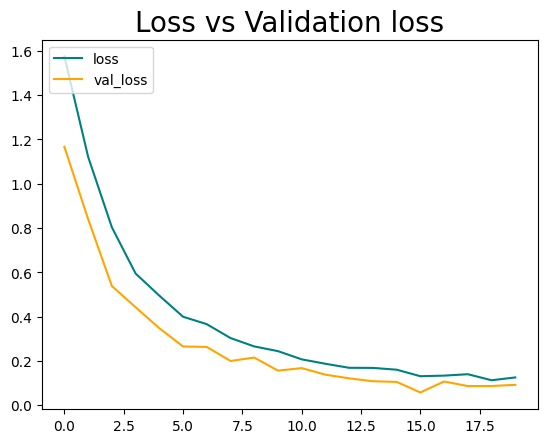

In [11]:
history = train_model(model, train, val, log_dir)

#### *Evaluate*

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


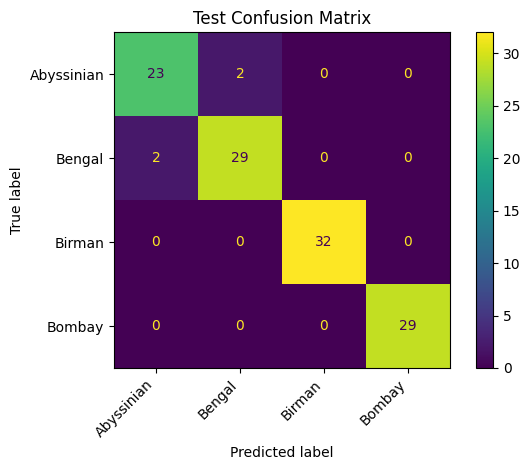

In [12]:
# Create a dataset for testing
datasets = { 'Test': test }

# Retrieve true and predicted labels
results = { name: get_true_and_pred_labels(model, data) for name, data in datasets.items() }

# Display results
display_confusion_matrices(results, classes)

#### *Predict*

Found 40 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


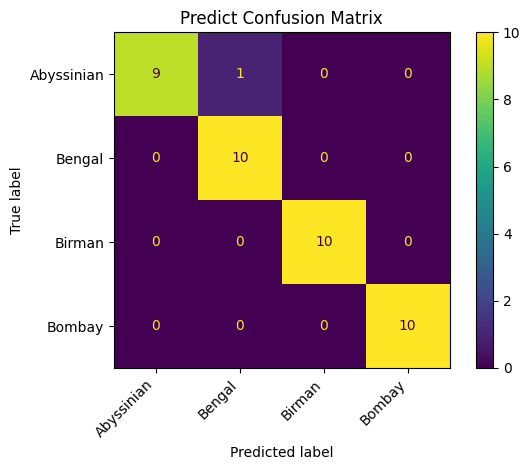

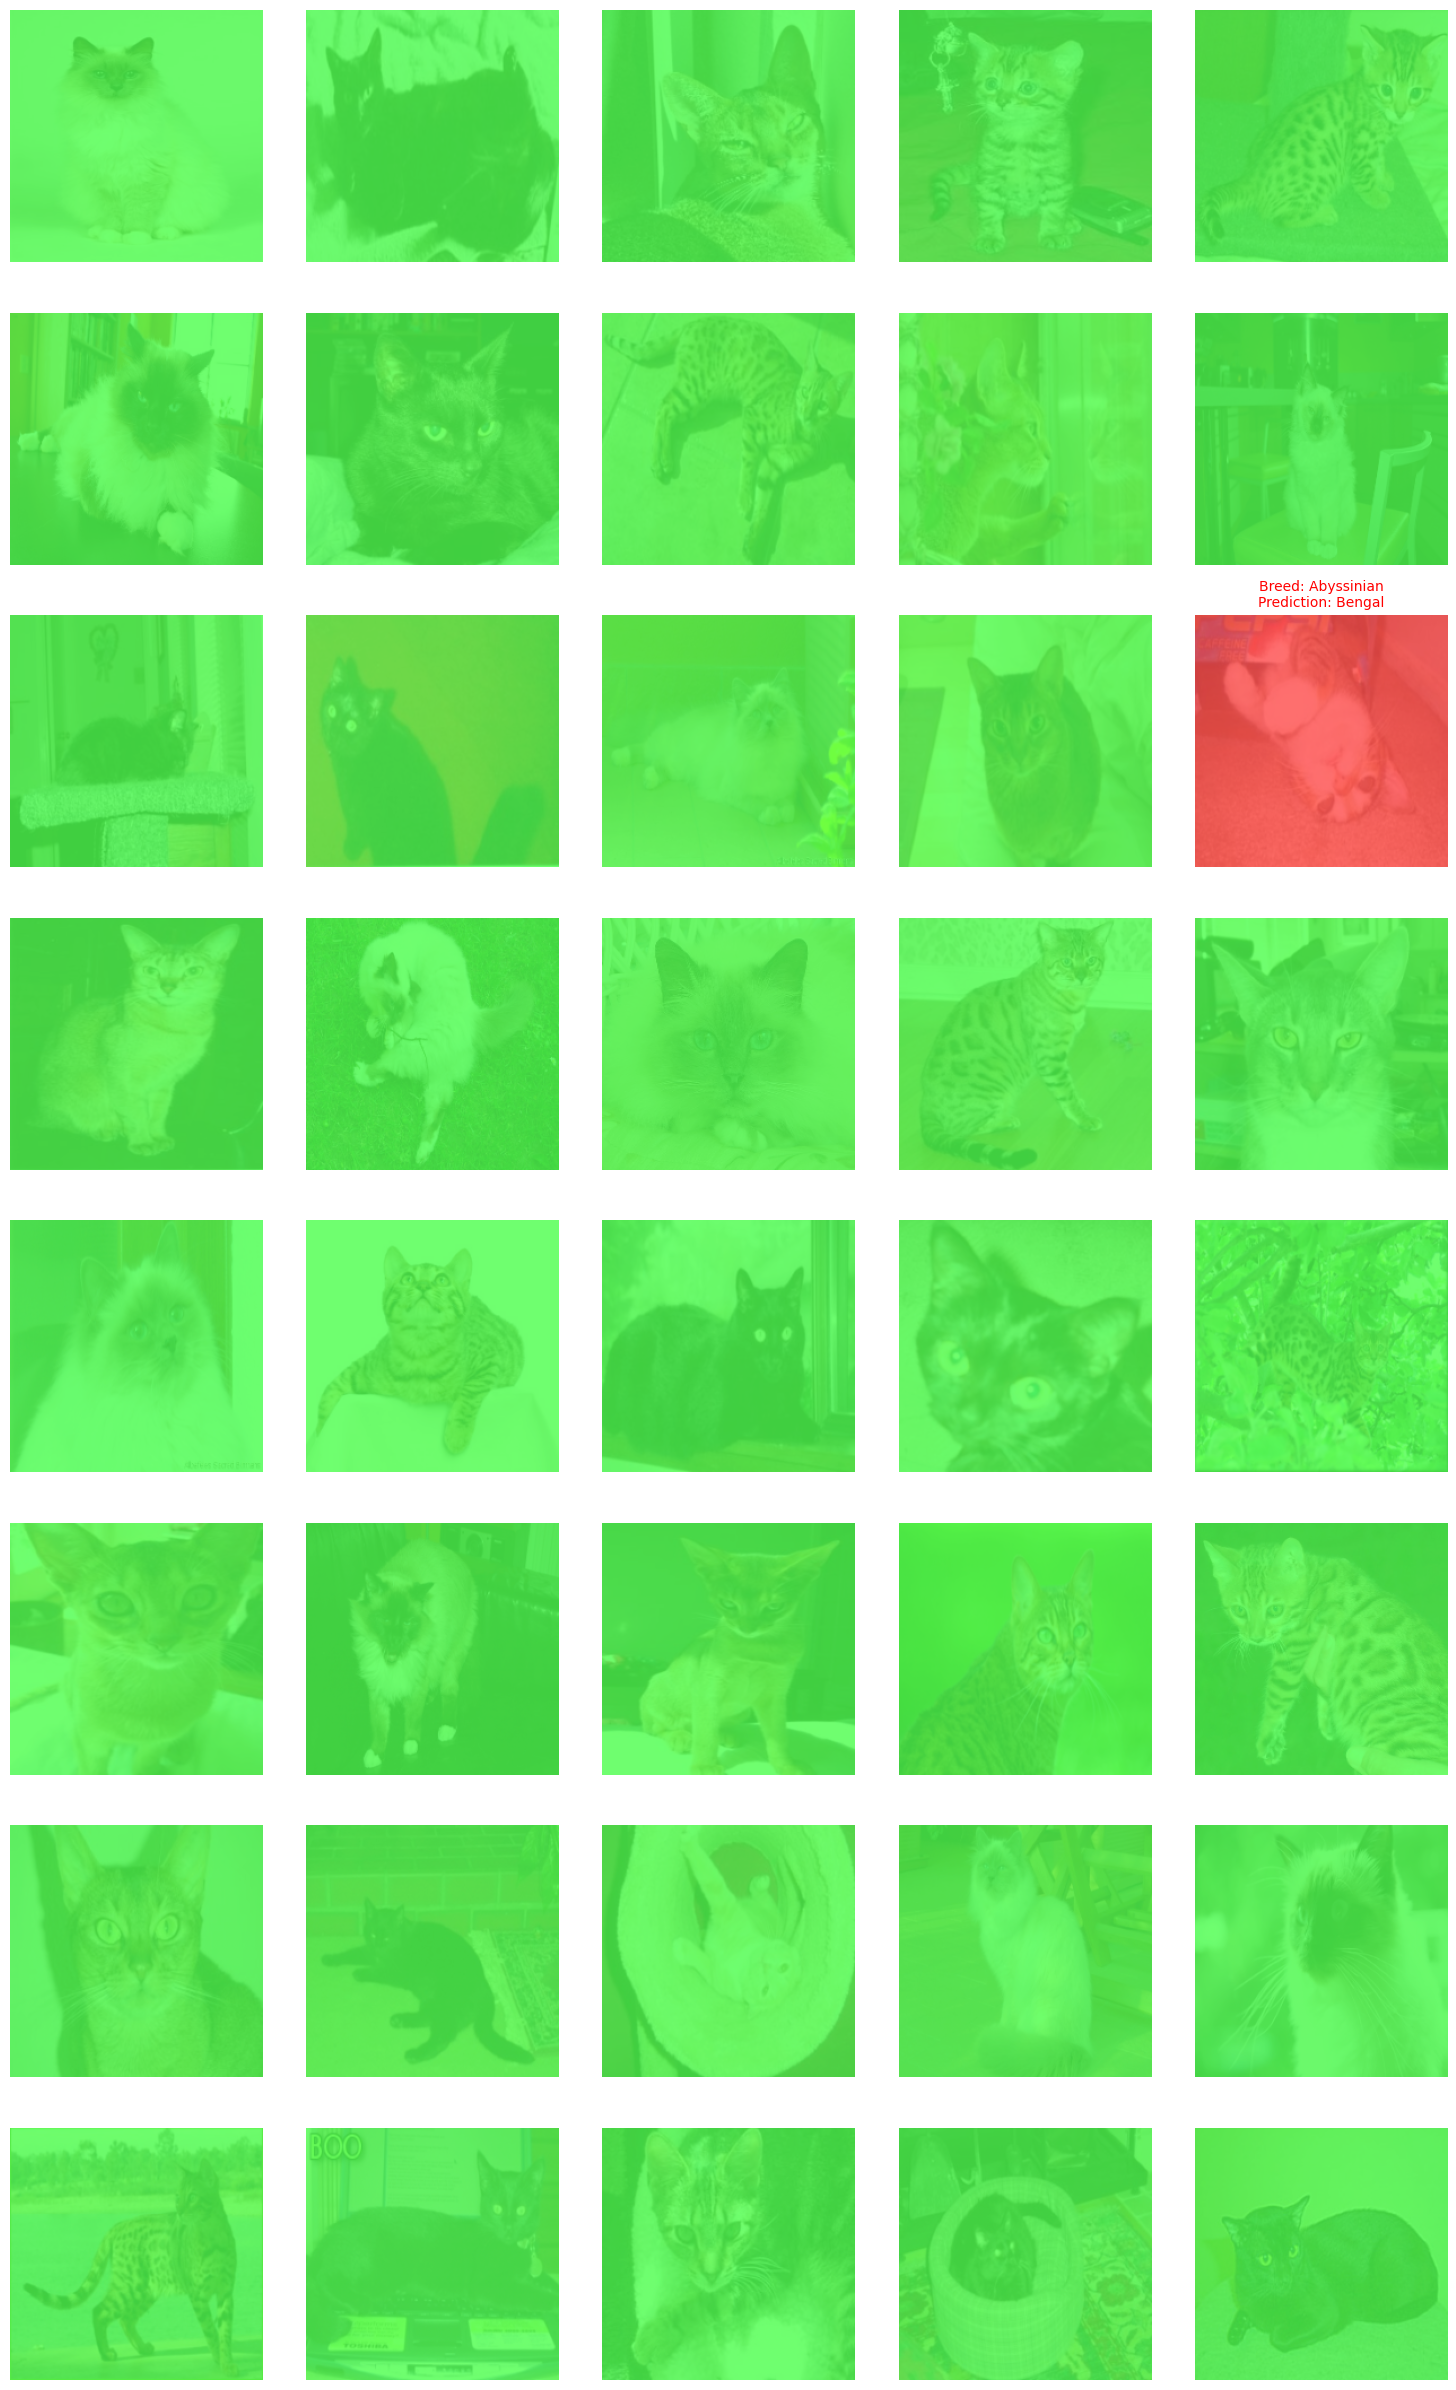

In [13]:
# Process images for the specified directory
processed_images, paths = process_images(predict_dir, image_exts)
preprocessed_images = preprocess_images(processed_images)

# Create a dataset for prediction
datasets = { 'Predict': preprocessed_images }

# Retrieve true and predicted labels
results = { name: get_true_and_pred_labels(model, data) for name, data in datasets.items() }
predicted_images, y_true, y_pred = results['Predict']

# Load and configure the base model
base_model = ks.applications.MobileNetV2(weights='imagenet')
base_model.layers[-1].activation = None

# Display results
display_confusion_matrices(results, classes)
display_images_with_overlay(predicted_images, y_true, y_pred, classes)

#### *Save*

In [14]:
save_model(model, models_dir)
save_class_names(classes, classes_dir)

Class names successfully saved to models/classes.json.
